In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from hmmlearn import hmm
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Hidden Markov Model Modifiable Parameters
hidden_states = 3
em_iterations = 75

# Fixed training period (2007-2017)
train_start_date = "2018-01-01"
train_end_date = "2024-12-31"

# Date parameters for yfinance API - download data from 1995 to present
start_date = "1995-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

print(f"Downloading SPY data from {start_date} to {end_date}...")
# Download data using yfinance
df = yf.download('SPY', start=start_date, end=end_date, auto_adjust=True)

# Fix the multi-level column structure
df.columns = df.columns.droplevel(1) if len(df.columns.names) > 1 else df.columns

# Reset index to make Date a column
df = df.reset_index()

# Display first few rows to check the structure
print("DataFrame structure:")
print("Data shape:", df.shape)
print("Data columns:", df.columns.tolist())
df.head()

[*********************100%***********************]  1 of 1 completed

DataFrame structure:
Data shape: (7620, 6)
Data columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']


Price,Date,Close,High,Low,Open,Volume
0,1995-01-03,26.815863,26.852471,26.760950,26.770102,324300
1,1995-01-04,26.944004,26.944004,26.797569,26.934852,351800
2,1995-01-05,26.944004,27.008069,26.916548,26.962308,89800
3,1995-01-06,26.971464,27.090442,26.889095,26.998921,448400
4,1995-01-09,26.998920,26.998920,26.944007,26.962312,36800


In [56]:
# Function to calculate technical indicators
def calculate_indicators(data):
    # Create a copy of the dataframe to avoid modifying original
    df_copy = data.copy()
    
    # Volatility is computed by obtaining variance between current close and prices of past 10 days
    volatility = []
    # MA is the 10 day SMA
    ma = []
    # Return is the single-day percentage return
    returns = []
    ma_sum = 0
    
    # Warming up data for moving average and volatility calculations
    for i in range(0, 10):
        volatility.append(0)
        ma.append(0)
        returns.append(0)
        ma_sum += df_copy['Close'].iloc[i]
    
    # Filling in data for return, moving average, and volatility
    for ind in range(len(df_copy)):
        if ind >= 10:
            tail_close = df_copy['Close'].iloc[ind-10]
            prev_close = df_copy['Close'].iloc[ind-1]
            head_close = df_copy['Close'].iloc[ind]
            ma_sum = (ma_sum - tail_close + head_close)
            ma_curr = ma_sum/10
            ma.append(ma_curr)
            returns.append(((head_close-prev_close)/prev_close)*100)
            # Computing Volatility
            vol_sum = 0
            for i in range(0, 10):
                curr_vol = abs(ma_curr - df_copy['Close'].iloc[ind-i])
                vol_sum += (curr_vol ** 2)
            volatility.append(vol_sum/10)
    
    # Adding columns to dataframe
    df_copy['Volatility'] = volatility
    df_copy['MA'] = ma
    df_copy['Return'] = returns
    
    return df_copy

# Calculate indicators for the entire dataset
df = calculate_indicators(df)
df.head(15)

Price,Date,Close,High,Low,Open,Volume,Volatility,MA,Return
0,1995-01-03,26.815863,26.852471,26.760950,26.770102,324300,0.000000,0.000000,0.000000
1,1995-01-04,26.944004,26.944004,26.797569,26.934852,351800,0.000000,0.000000,0.000000
2,1995-01-05,26.944004,27.008069,26.916548,26.962308,89800,0.000000,0.000000,0.000000
3,1995-01-06,26.971464,27.090442,26.889095,26.998921,448400,0.000000,0.000000,0.000000
4,1995-01-09,26.998920,26.998920,26.944007,26.962312,36800,0.000000,0.000000,0.000000
5,1995-01-10,27.026375,27.172810,27.026375,27.062984,229800,0.000000,0.000000,0.000000
6,1995-01-11,27.044676,27.117893,26.834176,27.117893,222400,0.000000,0.000000,0.000000
7,1995-01-12,27.053829,27.072134,26.962307,27.017220,40300,0.000000,0.000000,0.000000
8,1995-01-13,27.374155,27.374155,27.163655,27.200264,170600,0.000000,0.000000,0.000000
9,1995-01-16,27.538897,27.548049,27.365005,27.365005,105100,0.000000,0.000000,0.000000


In [57]:
# Function to train HMM model on specified period
def train_hmm_model(data, start_date, end_date, n_states=3, n_iter=75):
    # Filter data to training period
    training = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()
    
    print(f"Training model on data from {start_date} to {end_date}")
    print(f"Training data shape: {training.shape}")
    
    # Prepare observations for HMM (using Volatility and Return)
    obs = np.column_stack([training['Volatility'].values, training['Return'].values])
    
    # Create and train the HMM model
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=n_iter)
    model.fit(obs)
    
    # Get predictions for training data
    predictions = model.predict(obs)
    
    # Analyze regime characteristics
    regime_vol = [0] * n_states
    regime_ret = [0] * n_states
    regime_count = [0] * n_states
    return_map = {i: [] for i in range(n_states)}
    
    for i in range(len(predictions)):
        regime = predictions[i]
        regime_count[regime] += 1
        regime_vol[regime] += training['Volatility'].iloc[i]
        regime_ret[regime] += training['Return'].iloc[i]
        return_map[regime].append(training['Return'].iloc[i])
    
    # Calculate averages
    for i in range(n_states):
        if regime_count[i] > 0:  # Prevent division by zero
            regime_vol[i] = regime_vol[i] / regime_count[i]
            regime_ret[i] = regime_ret[i] / regime_count[i]
    
    # Print regime characteristics
    for i in range(n_states):
        print(f"Regime {i}")
        print(f"Avg Vol: {regime_vol[i]}")
        print(f"Avg Return: {regime_ret[i]}")
        print(f"Occurrence: {regime_count[i]}\n")
    
    return model, training, predictions

# Train the model on the fixed period (2007-2017)
model, training_data, train_predictions = train_hmm_model(df, train_start_date, train_end_date, 
                                                         hidden_states, em_iterations)

Training model on data from 2018-01-01 to 2024-12-31
Training data shape: (1761, 9)
Regime 0
Avg Vol: 4.801020422312424
Avg Return: 0.08457643612930471
Occurrence: 698

Regime 1
Avg Vol: 80.33591436756976
Avg Return: -0.01887298457081089
Occurrence: 326

Regime 2
Avg Vol: 20.47931484593282
Avg Return: 0.06841945804057169
Occurrence: 737



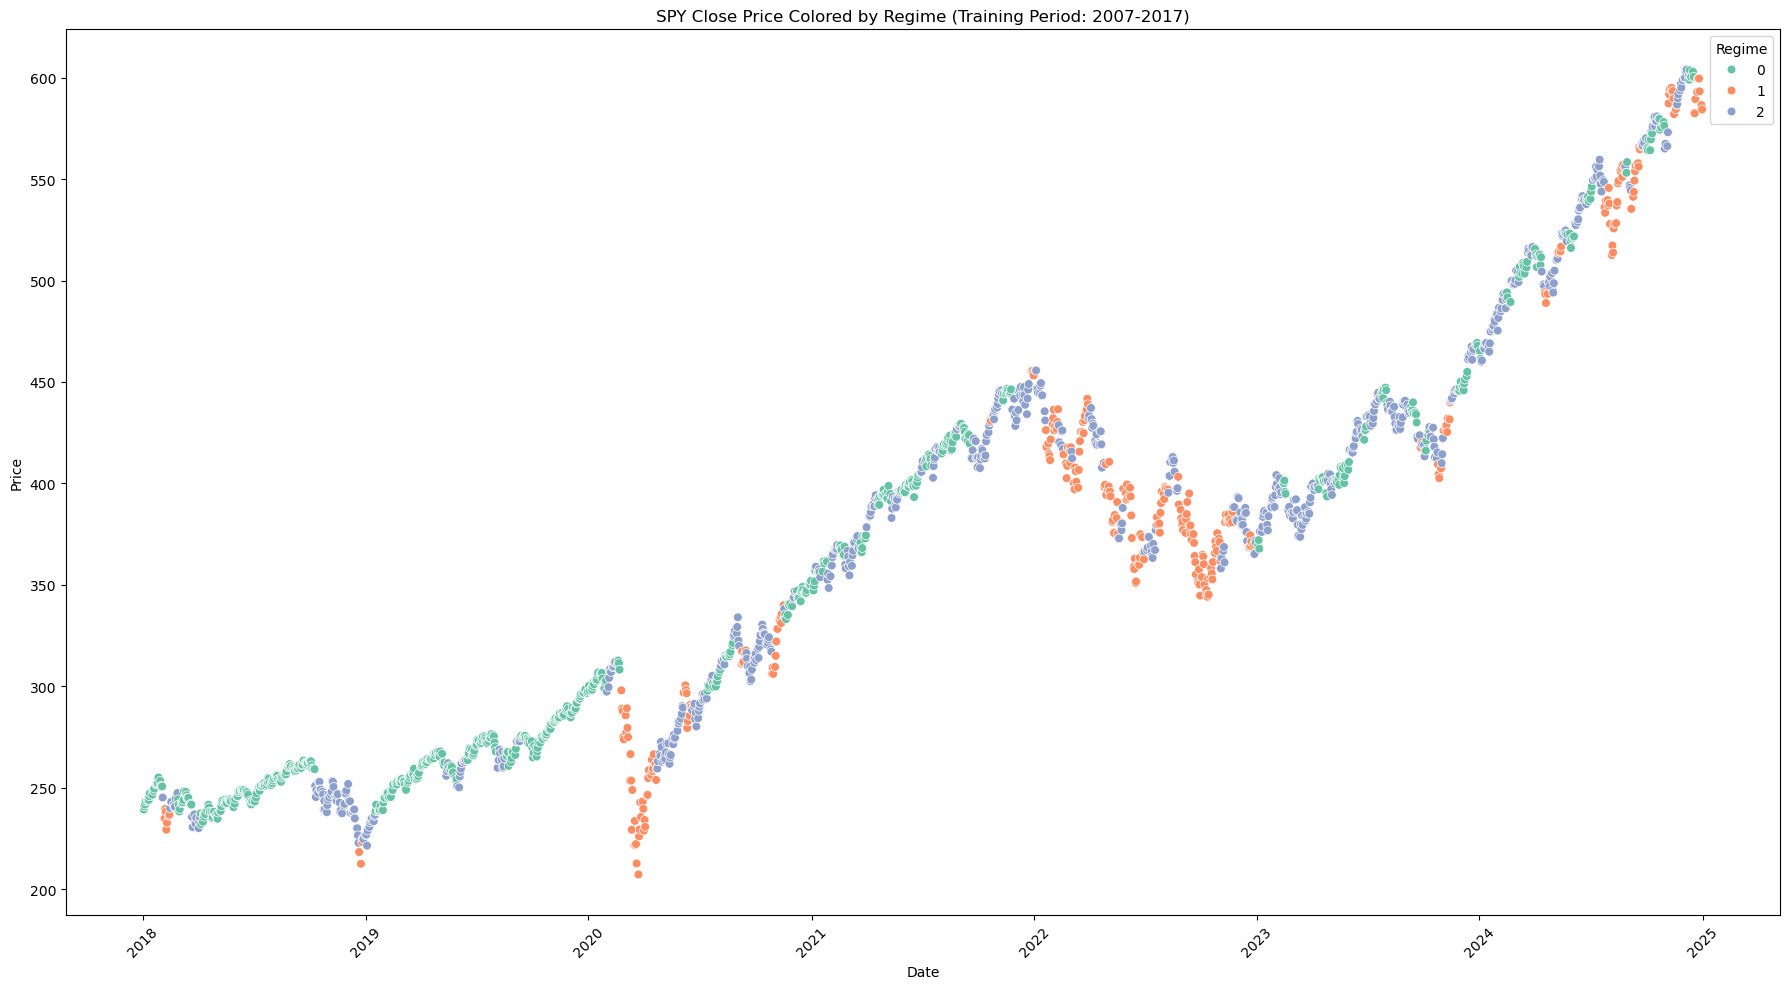

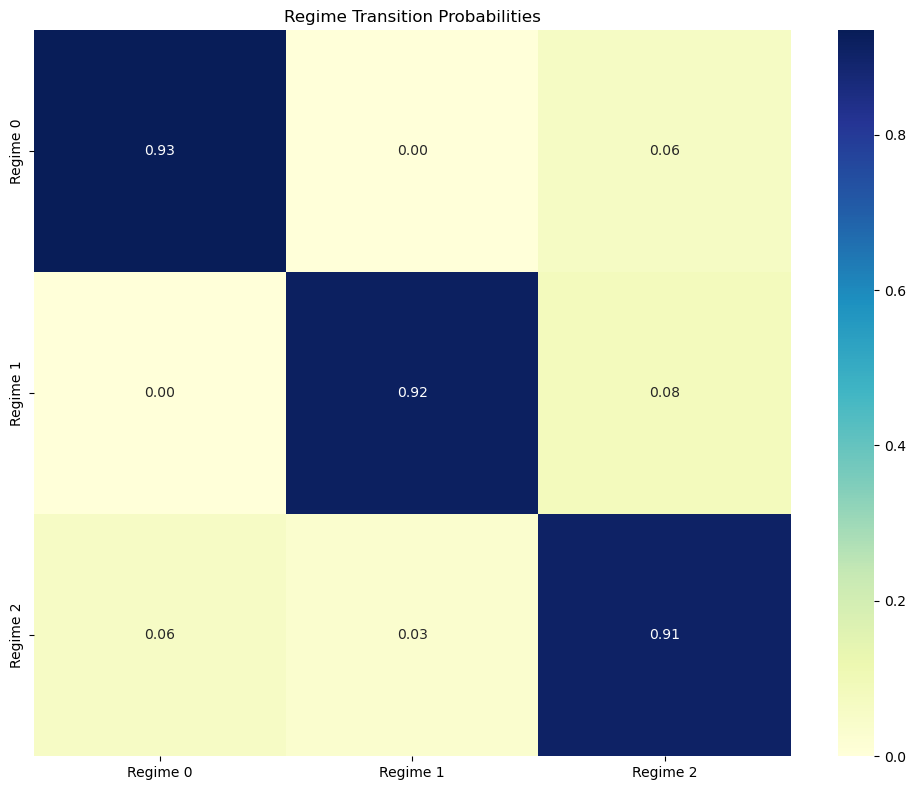


Stationary Distribution:
Regime 0: 38.67%
Regime 1: 18.86%
Regime 2: 42.47%


In [58]:
# Visualize the training data with regime classifications
training_with_predictions = training_data.copy()
training_with_predictions['Regime'] = train_predictions

plt.figure(figsize=(18, 10))
sns.scatterplot(x='Date', y='Close', 
                hue='Regime', data=training_with_predictions, 
                palette="Set2", s=40)
plt.title('SPY Close Price Colored by Regime (Training Period: 2007-2017)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize transition probabilities
transition_matrix = model.transmat_
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, cmap="YlGnBu", fmt=".2f",
           xticklabels=[f"Regime {i}" for i in range(hidden_states)],
           yticklabels=[f"Regime {i}" for i in range(hidden_states)])
plt.title('Regime Transition Probabilities')
plt.tight_layout()
plt.show()

# Show stationary distribution
stationary_dist = model.get_stationary_distribution()
print("\nStationary Distribution:")
for i in range(hidden_states):
    print(f"Regime {i}: {stationary_dist[i]*100:.2f}%")

In [59]:
# Function to predict regimes for a specific date range
def predict_regimes(model, data, start_date, end_date):
    """
    Predict market regimes for a specific date range using the trained HMM model
    
    Parameters:
    -----------
    model : hmm.GaussianHMM
        The trained HMM model
    data : DataFrame
        The full dataset with calculated indicators
    start_date : str
        Start date for prediction period in 'YYYY-MM-DD' format
    end_date : str
        End date for prediction period in 'YYYY-MM-DD' format
        
    Returns:
    --------
    DataFrame with date, close price, and predicted regime
    """
    # Filter data for prediction period
    pred_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()
    
    if len(pred_data) == 0:
        print(f"No data available for period {start_date} to {end_date}")
        if end_date > data['Date'].max().strftime('%Y-%m-%d'):
            print("NOTE: Prediction period extends into the future")
            # Generate future dates for forecasting
            last_date = data['Date'].max()
            future_end = datetime.strptime(end_date, '%Y-%m-%d')
            
            # Get the most recent 30 days of data for calculating indicators
            recent_data = data.tail(30).copy()
            
            # For future dates, we'll extend from the last value and assume zero returns
            # This is a simplification - in reality you might want to use a forecasting model
            current_date = last_date + timedelta(days=1)
            while current_date <= future_end:
                if current_date.weekday() < 5:  # Only include weekdays
                    new_row = {
                        'Date': current_date,
                        'Close': recent_data['Close'].iloc[-1],  # Use the last known close price
                        'High': recent_data['Close'].iloc[-1],
                        'Low': recent_data['Close'].iloc[-1],
                        'Open': recent_data['Close'].iloc[-1],
                        'Volume': recent_data['Volume'].mean(),  # Use average volume
                        'Volatility': recent_data['Volatility'].mean(),  # Use average volatility
                        'MA': recent_data['MA'].iloc[-1],  # Use the last MA
                        'Return': 0  # Assume zero returns for future dates
                    }
                    recent_data = pd.concat([recent_data, pd.DataFrame([new_row])], ignore_index=True)
                current_date += timedelta(days=1)
            
            # Keep only the future dates we generated
            future_data = recent_data[recent_data['Date'] > last_date].copy()
            pred_data = future_data[(future_data['Date'] >= start_date) & (future_data['Date'] <= end_date)].copy()
    
    # Prepare observations for prediction
    obs = np.column_stack([pred_data['Volatility'].values, pred_data['Return'].values])
    
    # Predict regimes
    predictions = model.predict(obs)
    
    # Add predictions to dataframe
    pred_data['Predicted_Regime'] = predictions
    
    print(f"Predicted regimes for period {start_date} to {end_date}")
    print(f"Data points: {len(pred_data)}")
    
    # Calculate regime distribution
    regime_counts = pd.Series(predictions).value_counts(normalize=True) * 100
    print("\nRegime Distribution:")
    for regime, percentage in regime_counts.items():
        print(f"Regime {regime}: {percentage:.2f}%")
    
    return pred_data[['Date', 'Close', 'Volatility', 'Return', 'Predicted_Regime']]

Predicted regimes for period 2024-01-01 to 2025-04-10
Data points: 320

Regime Distribution:
Regime 2: 48.44%
Regime 1: 30.00%
Regime 0: 21.56%


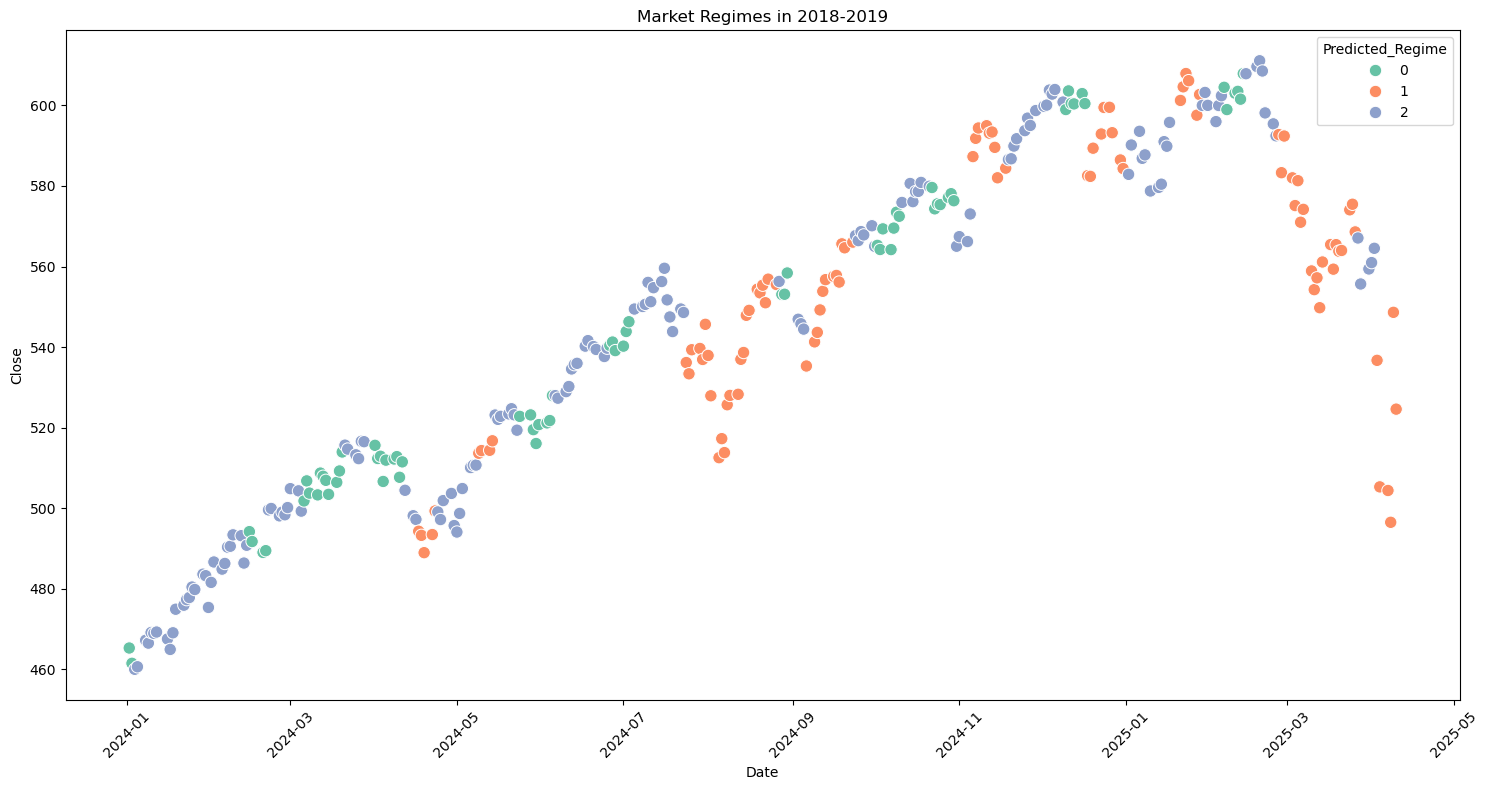

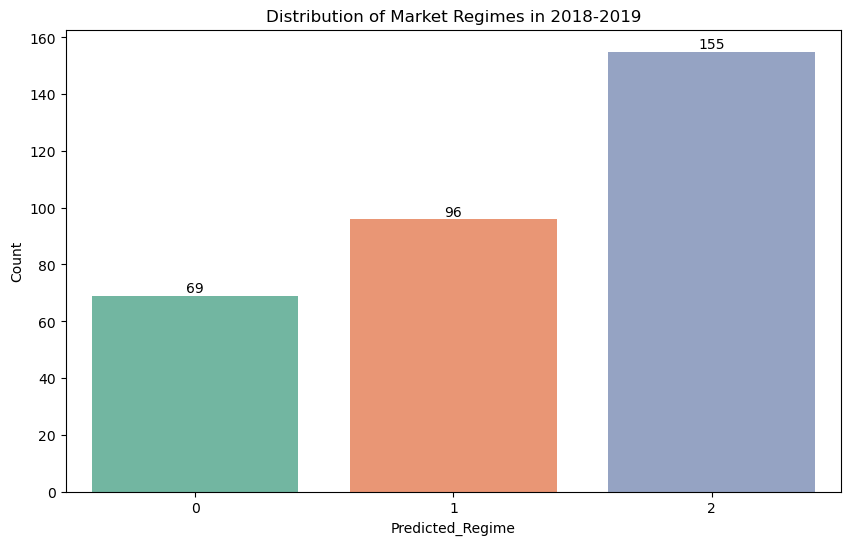

In [60]:
# Example 1: Predict regimes for a historical period (2018-2019)
results_2018_2019 = predict_regimes(model, df, "2024-01-01", "2025-04-10")

# Visualize the results
plt.figure(figsize=(15, 8))
sns.scatterplot(x='Date', y='Close', hue='Predicted_Regime', data=results_2018_2019, palette="Set2", s=80)
plt.title('Market Regimes in 2018-2019')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show distribution of regimes over time
regime_dist = results_2018_2019.groupby(['Predicted_Regime']).size().reset_index(name='Count')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Predicted_Regime', y='Count', data=regime_dist, palette="Set2")
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Distribution of Market Regimes in 2018-2019')
plt.show()

Predicted regimes for period 2025-01-11 to 2025-04-11
Data points: 62

Regime Distribution:
Regime 1: 53.23%
Regime 2: 35.48%
Regime 0: 11.29%


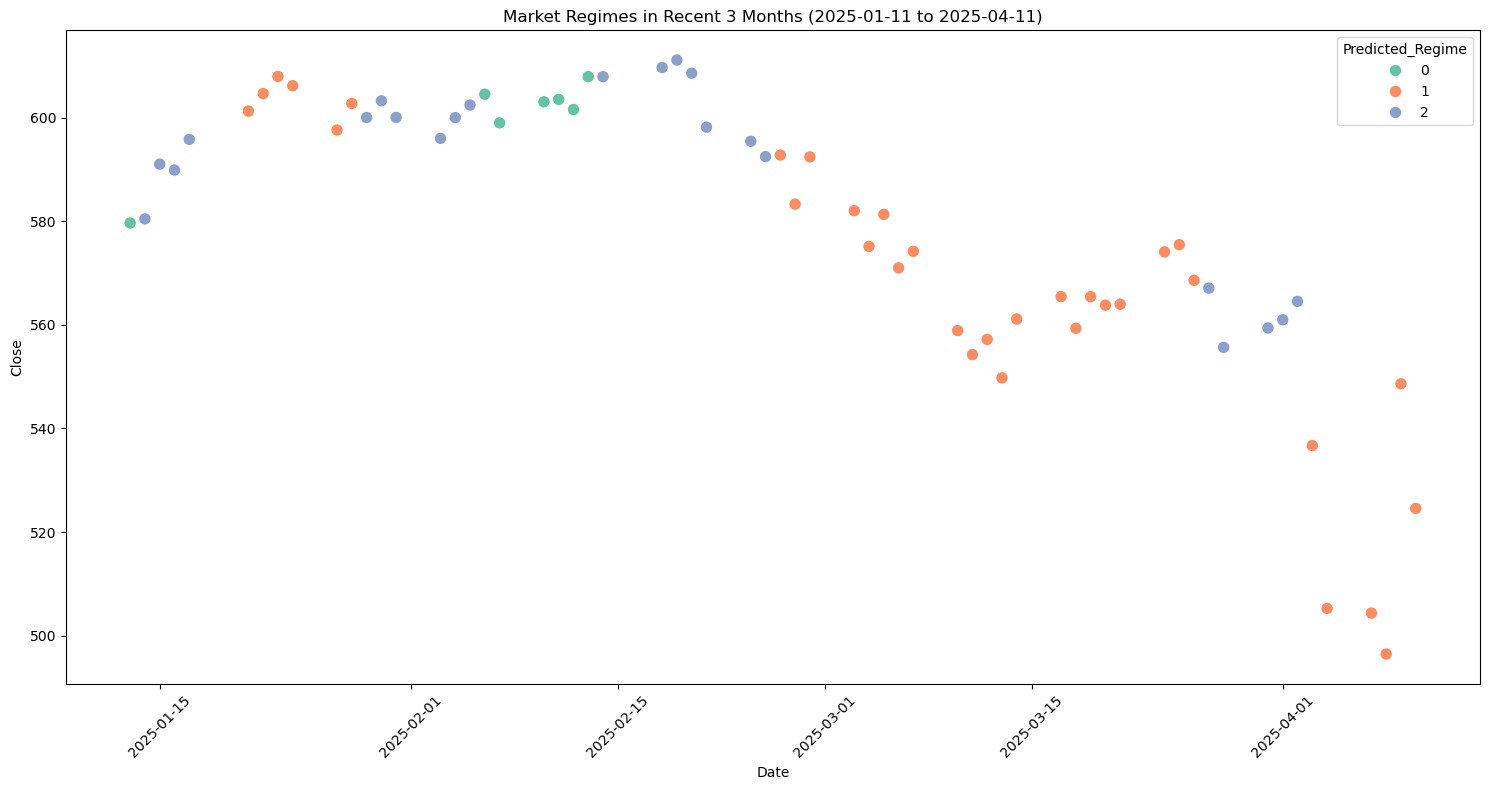

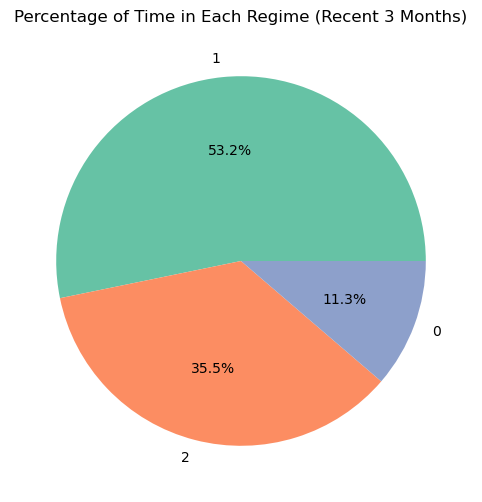

In [61]:
# Example 2: Predict regimes for the most recent 3 months
from datetime import datetime, timedelta

today = datetime.today()
three_months_ago = today - timedelta(days=90)

start_date = three_months_ago.strftime('%Y-%m-%d')
end_date = today.strftime('%Y-%m-%d')

recent_results = predict_regimes(model, df, start_date, end_date)

# Visualize recent results
plt.figure(figsize=(15, 8))
sns.scatterplot(x='Date', y='Close', hue='Predicted_Regime', data=recent_results, palette="Set2", s=80)
plt.title(f'Market Regimes in Recent 3 Months ({start_date} to {end_date})')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate percentage of time in each regime
regime_percentages = recent_results['Predicted_Regime'].value_counts(normalize=True) * 100
plt.figure(figsize=(10, 6))
regime_percentages.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("Set2"), figsize=(10, 6))
plt.title('Percentage of Time in Each Regime (Recent 3 Months)')
plt.ylabel('')
plt.show()

Predicted regimes for period 2025-01-01 to 2025-03-31
Data points: 60

Regime Distribution:
Regime 1: 45.00%
Regime 2: 43.33%
Regime 0: 11.67%

Predicted regimes for Q1 2025:


Price,Date,Close,Volatility,Return,Predicted_Regime
7552,2025-01-02,582.886597,40.444660,-0.245698,0
7553,2025-01-03,590.174622,35.377226,1.250333,2
7554,2025-01-06,593.574402,29.428019,0.576063,2
7555,2025-01-07,586.864624,30.909914,-1.130402,2
7556,2025-01-08,587.721985,31.294495,0.146092,2


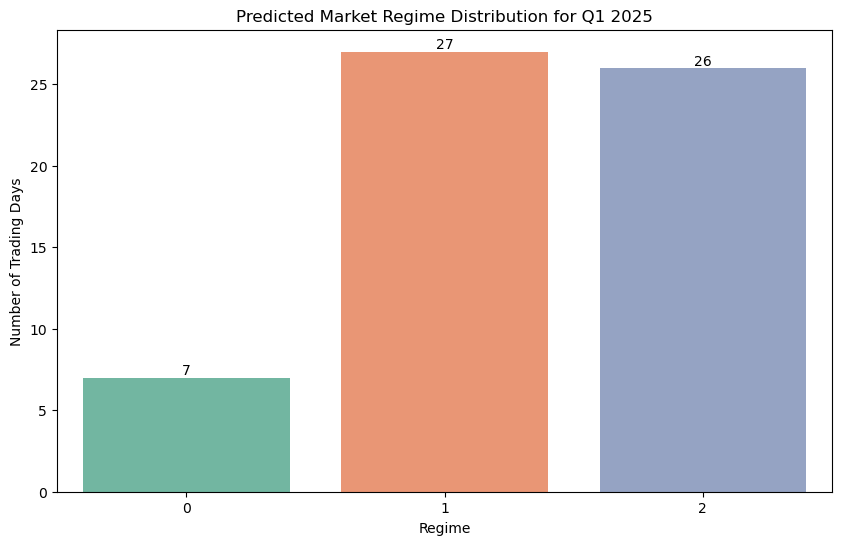

In [62]:
# Example 3: Predict regimes for future dates (Q1 2025)
future_start = "2025-01-01"
future_end = "2025-03-31"

future_results = predict_regimes(model, df, future_start, future_end)

# Display predictions for future dates
if future_results is not None and not future_results.empty:
    print("\nPredicted regimes for Q1 2025:")
    display(future_results.head())

    # Visualize the distribution of predicted regimes for Q1 2025
    plt.figure(figsize=(10, 6))
    regime_counts = future_results['Predicted_Regime'].value_counts()
    ax = sns.barplot(x=regime_counts.index, y=regime_counts.values, palette="Set2")
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title('Predicted Market Regime Distribution for Q1 2025')
    plt.xlabel('Regime')
    plt.ylabel('Number of Trading Days')
    plt.show()

In [63]:
# Function to create a custom prediction for any date range
def custom_regime_prediction(start_date, end_date):
    """
    Predict regimes for a custom date range
    
    Parameters:
    -----------
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    """
    results = predict_regimes(model, df, start_date, end_date)
    
    # Visualize the results
    plt.figure(figsize=(15, 8))
    sns.scatterplot(x='Date', y='Close', hue='Predicted_Regime', data=results, palette="Set2", s=80)
    plt.title(f'Market Regimes from {start_date} to {end_date}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results

# Example usage - uncomment and modify dates as needed:
# custom_results = custom_regime_prediction("2020-03-01", "2020-06-30")  # COVID-19 market crash period

In [64]:
# Regime Characteristics Summary
regime_vol = [0] * hidden_states
regime_ret = [0] * hidden_states
regime_count = [0] * hidden_states

for i in range(len(train_predictions)):
    regime = train_predictions[i]
    regime_count[regime] += 1
    regime_vol[regime] += training_data['Volatility'].iloc[i]
    regime_ret[regime] += training_data['Return'].iloc[i]

for i in range(hidden_states):
    if regime_count[i] > 0:
        regime_vol[i] = regime_vol[i] / regime_count[i]
        regime_ret[i] = regime_ret[i] / regime_count[i]

# Create a summary dataframe
regime_summary = pd.DataFrame({
    'Regime': range(hidden_states),
    'Average_Volatility': regime_vol,
    'Average_Return': regime_ret,
    'Occurrence_Count': regime_count,
    'Occurrence_Percentage': [count/sum(regime_count)*100 for count in regime_count]
})

# Display the summary
print("HMM Market Regime Summary (Training Period: 2007-2017)")
display(regime_summary)

# Interpret the regimes based on their characteristics
print("\nMarket Regime Interpretation:")
for i in range(hidden_states):
    regime_type = ""
    if regime_ret[i] > 0.05:
        if regime_vol[i] < 1:
            regime_type = "Stable Growth (Low Volatility, Positive Returns)"
        else:
            regime_type = "Volatile Growth (High Volatility, Positive Returns)"
    elif regime_ret[i] < 0:
        if regime_vol[i] > 2:
            regime_type = "Bear Market (High Volatility, Negative Returns)"
        else:
            regime_type = "Correction (Moderate Volatility, Negative Returns)"
    else:
        regime_type = "Sideways Market (Moderate Volatility, Flat Returns)"
    
    print(f"Regime {i}: {regime_type}")

HMM Market Regime Summary (Training Period: 2007-2017)


,Regime,Average_Volatility,Average_Return,Occurrence_Count,Occurrence_Percentage
0,0,4.801020,0.084576,698,39.636570
1,1,80.335914,-0.018873,326,18.512209
2,2,20.479315,0.068419,737,41.851221



Market Regime Interpretation:
Regime 0: Volatile Growth (High Volatility, Positive Returns)
Regime 1: Bear Market (High Volatility, Negative Returns)
Regime 2: Volatile Growth (High Volatility, Positive Returns)
